In [114]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import sklearn.linear_model as linear_model

Отключим предупреждения, ибо задолбают знатно

In [115]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

Как и делали ранее считываем файл и из поля datetime делаем несколько категориальных признаков (час, день, месяц) + удалим, те поля, что уже находили ранее

In [116]:
data = pd.read_csv("data/train.csv")
dt = pd.to_datetime(data["datetime"])
data["hour"] = dt.map(lambda x: x.hour)
data["day"] = dt.map(lambda x: x.day)
data["month"] = dt.map(lambda x: x.month)
data = data.drop(['datetime', 'registered', 'casual'], axis=1)
data.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,hour,day,month
0,1,0,0,1,9.84,14.395,81,0.0,16,0,1,1
1,1,0,0,1,9.02,13.635,80,0.0,40,1,1,1
2,1,0,0,1,9.02,13.635,80,0.0,32,2,1,1
3,1,0,0,1,9.84,14.395,75,0.0,13,3,1,1
4,1,0,0,1,9.84,14.395,75,0.0,1,4,1,1


Чисто, чтоб было удобнее работать:

In [118]:
data = data[['hour','day','month','season','holiday','workingday',
             'weather','temp','atemp','humidity','windspeed', 'count']]
data.head()

,hour,day,month,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,0,1,1,1,0,0,1,9.84,14.395,81,0.0,16
1,1,1,1,1,0,0,1,9.02,13.635,80,0.0,40
2,2,1,1,1,0,0,1,9.02,13.635,80,0.0,32
3,3,1,1,1,0,0,1,9.84,14.395,75,0.0,13
4,4,1,1,1,0,0,1,9.84,14.395,75,0.0,1


In [119]:
X_data = data.drop(['count'], axis=1)
Y_data = data['count']
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.25)

In [120]:
def getPredictSGDRegressor(x_train, y_train, x_test):
    scaler = StandardScaler()
    scaler.fit(x_train, y_train)
    X_scaled = scaler.transform(x_train)
    X_scaled_test = scaler.transform(x_test)
    sgdRegressor = linear_model.SGDRegressor()
    sgdRegressor.fit(X_scaled, y_train)
    return sgdRegressor.predict(X_scaled_test)

Собираем регрессию со всеми признаками, включая категориальные и считаем ошибку:

In [121]:
predict = getPredictSGDRegressor(X_train, Y_train, X_test)
metrics.mean_squared_error(Y_test, predict)

22393.990568637437

Теперь удалим категориальне признаки из тренировочной и тестовой выборок, вновь соберем регрессию и посчитаем ошибку:

In [122]:
X_train_without_cats = X_train.drop(X_train.columns[range(7)], axis=1)
X_train_without_cats.head()

,temp,atemp,humidity,windspeed
5386,10.66,12.880,60,15.0013
1844,28.70,32.575,48,27.9993
7974,27.06,29.545,89,12.9980
1112,13.94,17.425,0,6.0032
4490,20.50,24.240,94,12.9980


In [123]:
X_test_without_cats = X_test.drop(X_test.columns[range(7)], axis=1)
X_test_without_cats.head()

,temp,atemp,humidity,windspeed
1163,13.94,16.665,66,11.0014
3036,27.06,31.060,61,11.0014
1562,18.86,22.725,88,23.9994
552,10.66,11.365,60,23.9994
3087,32.80,37.120,49,19.9995


In [124]:
predict = getPredictSGDRegressor(X_train_without_cats, Y_train, X_test_without_cats)
metrics.mean_squared_error(Y_test, predict)

25653.642912148982

Теперь собираем с One-Hot-Encode признаками регрессию и снова считаем ошибку:

In [125]:
OHE = OneHotEncoder(sparse=False, categorical_features=range(7))
OHE = OHE.fit_transform(X_data)

X_train_OHE, X_test_OHE, Y_train, Y_test = train_test_split(OHE, Y_data, test_size=0.25)

In [126]:
predict = getPredictSGDRegressor(X_train_OHE, Y_train, X_test_OHE)
metrics.mean_squared_error(Y_test, predict)

16757.983904055593

С OHE ошибка заметно ниже

Подумаем, чтобы удалить

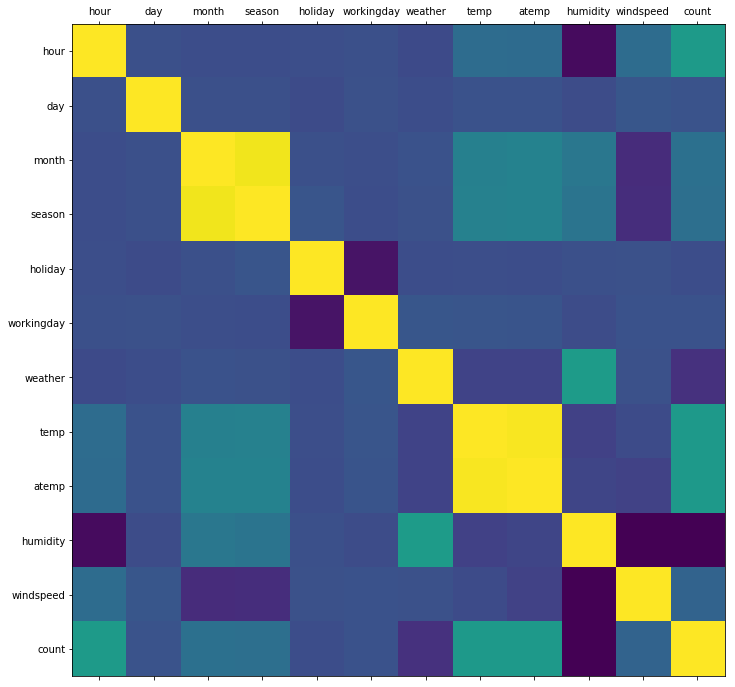

In [127]:
COUNT_COLUMNS = len(data.columns)
correlation = data.corr()
fig, ax = plt.subplots(figsize=(COUNT_COLUMNS, COUNT_COLUMNS))
ax.matshow(correlation)
plt.xticks(range(COUNT_COLUMNS), correlation.columns)
plt.yticks(range(COUNT_COLUMNS), correlation.columns)
plt.show()

Выкенем 'season' и 'atemp', и повторям всю процидуру с OHE

In [128]:
OHE = OneHotEncoder(sparse=False, categorical_features=range(6))
OHE = OHE.fit_transform(X_data.drop(['season', 'atemp'], axis=1))

X_train_OHE, X_test_OHE, Y_train, Y_test = train_test_split(OHE, Y_data, test_size=0.25)
predict = getPredictSGDRegressor(X_train_OHE, Y_train, X_test_OHE)
metrics.mean_squared_error(Y_test, predict)

12213.835245968572

In [ ]:
Ура, стало лучше